# Degree Distribution in PyC Subgraph (Th=0)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

## Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [3]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [4]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [6]:
import ast
def string2array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [7]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [8]:
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

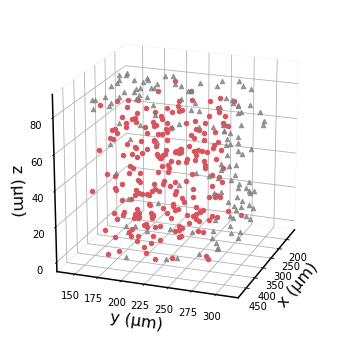

In [56]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
th = 0

for n in locs.keys():
    (x, y, z) = locs[n] / 1000
    if axls[n] <= th:
        ax.scatter(x, y, z, c='gray', marker='^', alpha=0.8)
    else:
        ax.scatter(x, y, z, c='#D8545D', marker='o')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('   x (μm)', fontsize=16)
ax.set_ylabel('y (μm)', fontsize=16)
ax.set_zlabel('z (μm)', fontsize=16)

ax.view_init(20, 20)

plt.show()
fig.savefig("figures/th0/th0_loc.pdf", bbox_inches='tight')

In [10]:
g_th0 = get_thresholded_graph(g_actual, axls, 0)
print(nx.info(g_th0))

Name: 
Type: DiGraph
Number of nodes: 229
Number of edges: 1264
Average in degree:   5.5197
Average out degree:   5.5197


In [11]:
nx.is_weakly_connected(g_th0)

False

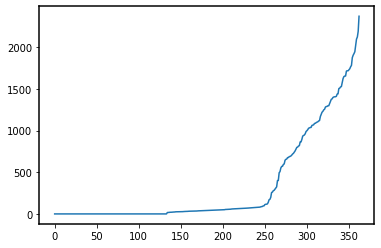

In [24]:
plt.plot(np.sort(list(axls.values())))

## Compare the Degree Distribution with ER model

In [12]:
# in-degree sequence
aic = np.array([g_th0.in_degree(n) for n in g_th0.nodes()])
# out-degree sequence
aoc = np.array([g_th0.out_degree(n) for n in g_th0.nodes()])

In [13]:
def er_sample_degs(g, p, selfloop=True):
    cp_indegs = []
    cp_outdegs = []
    for i in range(100):
        if selfloop:
            # ER model with selfloop
            edges = g.edges()
            inds = np.random.choice([True, False], len(edges), p=[p, 1-p])
            edges = np.array(edges)[inds]
            g_sampled = nx.DiGraph()
            g_sampled.add_nodes_from(g.nodes())
            g_sampled.add_edges_from(edges)
        else:
            g_sampled = nx.erdos_renyi_graph(len(g.nodes()), p, directed=True)
            
        cp_indegs.append([g_sampled.in_degree(n) for n in g_sampled.nodes()])
        cp_outdegs.append([g_sampled.out_degree(n) for n in g_sampled.nodes()])
    cp_indegs = np.array(cp_indegs).reshape(-1)
    cp_outdegs = np.array(cp_outdegs).reshape(-1)
    return cp_indegs, cp_outdegs

In [14]:
%%time
g_complete = nx.complete_graph(len(g_th0.nodes()), nx.DiGraph())
p_connect = len(g_th0.edges) / len(g_complete.edges)
ric_sample, roc_sample = er_sample_degs(g_complete, p_connect)

CPU times: user 3.96 s, sys: 156 ms, total: 4.12 s
Wall time: 4.12 s


In [15]:
def hist_outline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)
    histIn = np.insert(histIn, 0, 0)
    histIn = np.append(histIn, 0)
    bins = [t for b in zip(binsIn, binsIn) for t in b]
    data = [t for b in zip(histIn[:-1], histIn[1:]) for t in b]
    return (bins, data)

def overlay_hists_log(x, y, xlabels, ylabels, title, density=False, nbins=8, fname="temp"):
    f, axes = plt.subplots(2, 2, figsize=(12,8)) 
    for axs, d, dlabels in zip(axes, (x,y), (xlabels, ylabels)):
        ex = -0.2
        colors = ["#D8545D", "k"]
        lss = ["-", "--"]
        bins = np.linspace(0, np.max([np.max(di) for di in d]), nbins)
        bins_exp = np.concatenate(([ex], np.e**np.linspace(0, np.log(np.max([np.max(di) for di in d])), nbins)))
        for l, di, c, ls in zip(dlabels, d, colors, lss):
            nzx = di.astype(np.float)
            nzx[nzx == 0] = np.e**ex
            dx, dy = hist_outline(di, bins=bins, density=density)
            dx_exp, dy_exp = hist_outline(nzx, bins=bins_exp, density=density)
            if (l == "Expected from ER") or (l == "Expected from ER(ge)") and not density:
                dy = np.array(dy) / 100
                dy_exp = np.array(dy_exp) / 100
            axs[0].plot(dx, dy, label=l, c=c, linestyle=ls)
            axs[1].plot(dx_exp, np.array(dy_exp), label=l, c=c, linestyle=ls)
        axs[0].legend(loc='best', fontsize=14)
        axs[1].legend(loc='best', fontsize=14)
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[0].tick_params(length=8, width=1.5, labelsize=14)
        axs[1].tick_params(length=8, width=1.5, labelsize=14)
    axes[0][0].set_xlabel('In degree', fontsize=20);
    axes[0][1].set_xlabel('In degree', fontsize=20);
    axes[0][0].set_ylabel('Number of cells', fontsize=20);
    axes[0][1].set_ylabel('Number of cells', fontsize=20);
    axes[1][0].set_xlabel('Out degree', fontsize=20)
    axes[1][1].set_xlabel('Out degree', fontsize=20);
    axes[1][0].set_ylabel('Number of cells', fontsize=20);
    axes[1][1].set_ylabel('Number of cells', fontsize=20);
    f.suptitle(title, fontsize=20);
    f.tight_layout(rect=[0,0,1,0.94])
    f.savefig("figures/{}.pdf".format(fname), bbox_inches='tight')

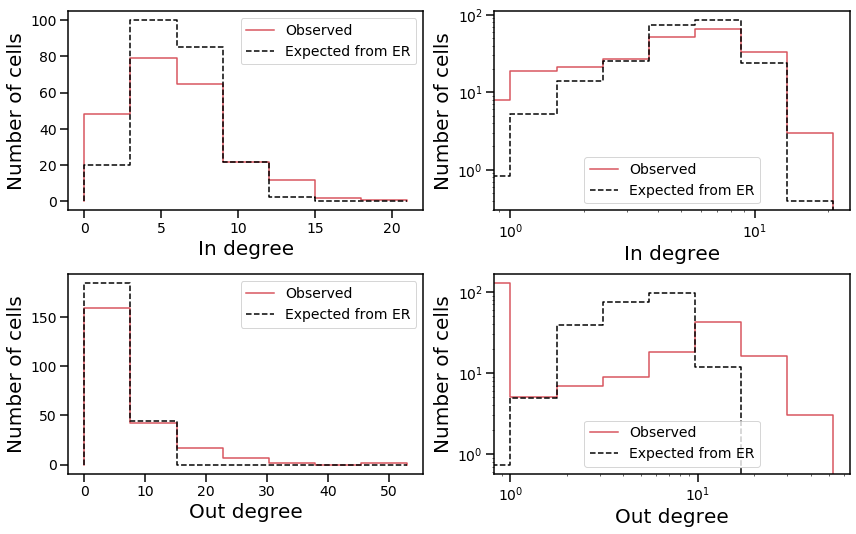

In [16]:
overlay_hists_log([aic, ric_sample], 
                  [aoc, roc_sample], 
                  ['Observed', 'Expected from ER'], 
                  ['Observed', 'Expected from ER'], 
                  title='', density=False, fname="th0/th0_degree_distribution")

In [17]:
three_pr, two_pr = compute_three_neuron_motif_probabilities_GE(g_th0)

In [18]:
two_pr

{'pr_uni': 0.02302152761817207,
 'pr_bi': 0.0011874664828008888,
 'pr_null': 0.952769478280855}

In [19]:
ug_complete = nx.complete_graph(len(g_th0.nodes()))

In [20]:
def er_gr_sample_degs(ug, p_uni, p_bi, selfloop=True):
    cp_indegs = []
    cp_outdegs = []
    for i in range(100):
        if selfloop:
            # ER model with selfloop
            edges = []
            for e in ug.edges():
                a = np.random.rand()
                if a < p_uni: 
                    edges.append(e)
                elif a < 2*p_uni: 
                    edges.append(e[::-1])
                elif a < 2*p_uni + p_bi: 
                    edges.append(e)
                    edges.append(e[::-1])
            g_sampled = nx.DiGraph()
            g_sampled.add_nodes_from(ug.nodes())
            g_sampled.add_edges_from(edges)
        else:
            g_sampled = nx.erdos_renyi_graph(len(ug.nodes()), p, directed=True)
        cp_indegs.append([g_sampled.in_degree(n) for n in g_sampled.nodes()])
        cp_outdegs.append([g_sampled.out_degree(n) for n in g_sampled.nodes()])
    cp_indegs = np.array(cp_indegs).reshape(-1)
    cp_outdegs = np.array(cp_outdegs).reshape(-1)
    return cp_indegs, cp_outdegs

In [21]:
%%time
ge_ric_sample, ge_roc_sample = er_gr_sample_degs(ug_complete, two_pr["pr_uni"], two_pr["pr_bi"])

CPU times: user 2.36 s, sys: 4 ms, total: 2.36 s
Wall time: 2.37 s


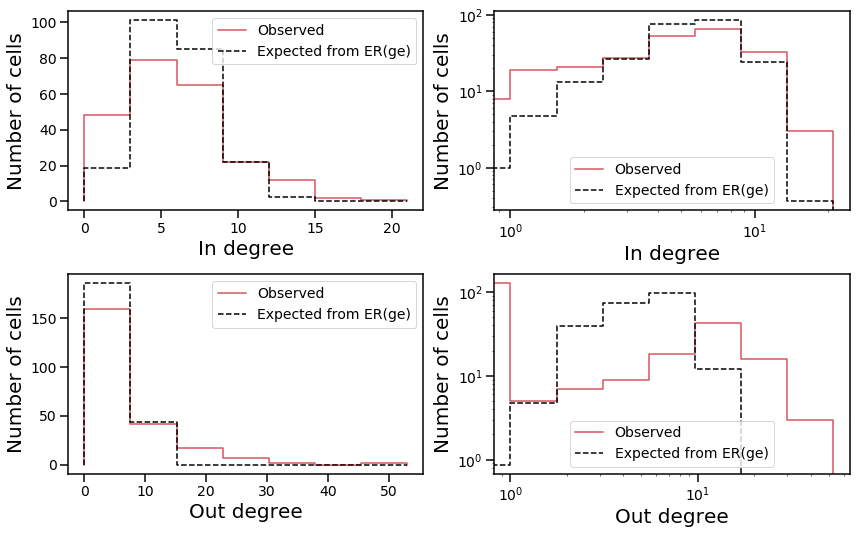

In [22]:
overlay_hists_log([aic, ge_ric_sample], 
                  [aoc, ge_roc_sample], 
                  ['Observed', 'Expected from ER(ge)'], 
                  ['Observed', 'Expected from ER(ge)'], 
                  title='', density=False, fname="th0/th0_degree_distribution_ge")